# Machine Learning: Predicting Employees' Promotion Outcomes

### Yifei Huang
Email: yifei@caltech.edu

## Preparing the Dataset

In [158]:
# Importing packages
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats as st
from time import time
from operator import itemgetter

import os
import subprocess
import pydot 
from IPython.display import Image  
from socket import socket

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
# Import datasets
dataset = pd.read_csv('dataset.csv')
dataset['joindt'] = dataset['joindt'].map(lambda x:int(x[-2:]))

# Dataset with selected features
data = pd.DataFrame(dataset, columns = ['code', 'leave', 'promotion' ,'yr', 'prerank', 'gender', 'certif', 'P_tenure', 'P_task', 'P_evaluation', 'P_license', 'P_absence', 'P_degree', 'percentile_dep', 'percentile_yr', 'percentile_dep_head', 'prank_dep_head', 'tenure', 'age',  'joindt', 'education', 'just_certificate', 'just_promoted', 'num_ratings_peers_ratio', 'num_ratings_peers', 'prank_peers_head', 'percentile_peers_head'])
data = pd.get_dummies(data) 
data = data.dropna(subset = ['code', 'promotion']) # only one observation is dropped

# The dataset with additional features through feature engineering over 360-degree appraisal ratings
distances = pd.read_csv('distances.csv') 
data_augmented = pd.merge(data, distances, how='left')

# Fill missing values with the mean
data_augmented = data_augmented.fillna(data_augmented.mean(), inplace=True)
data_augmented = data_augmented.convert_objects(convert_numeric=True)

print data.shape
print data_augmented.shape

features_dist = distances.columns.values.tolist()[1:]
print "The additional four features extracted:"
print features_dist

(494, 28)
(494, 32)
The additional four features extracted:
['distance_concensus', 'distance_leader', 'n_pairs_concensus', 'n_pairs_leader']


In [4]:
y = data_augmented['promotion']
X = data_augmented.drop(['promotion', 'code'], 1)

X_train_aug, X_test_aug, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = X_train_aug.drop(features_dist, 1)
X_test = X_test_aug.drop(features_dist, 1)
print X_train_aug.shape, X_test_aug.shape
print X_train.shape, X_test.shape

(395, 30) (99, 30)
(395, 26) (99, 26)


## Setup Utility Functions

In [189]:
def report(grid_scores, n_top=3):
    """
    For reporting best models
    Credit: dustinstansbury@GitHub
    """
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [190]:
def predict_prob(fitted_model, X):
    '''
    Computing the predicted probability for the positive outcome using test features
    '''
    p = fitted_model.predict_proba(X)
    p_positive = p[:,1]
    return p_positive

In [200]:
def plot_roc(fitted_model, X):
    """
    Utility function for plotting the ROC curve
    """
    p = predict_prob(fitted_model, X)
    fpr, tpr, roc_thresholds = roc_curve(y_test, p)
    print "ROC_AUC:", roc_auc_score(y_test, p)
    plt.subplots( figsize=(10, 6) ) 
    plt.plot(fpr, tpr, '-', linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate ("Cost")')
    plt.ylabel('True Positive Rate ("Benefit")')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")   
    plt.show()

In [236]:
def plot_two_rocs(model1, X1, c1, label1, model2, X2, c2, label2):
    p1 = predict_prob(model1, X1)
    fpr1, tpr1, roc_thresholds1 = roc_curve(y_test, p1)
    p2 = predict_prob(model2, X2)
    fpr2, tpr2, roc_thresholds2 = roc_curve(y_test, p2)
   
    plt.subplots( figsize=(10, 6) ) 
    plt.plot(fpr1, tpr1, '-', linewidth=3, color = c1, label = label1)
    plt.plot(fpr2, tpr2, '-', linewidth=3, color = c2, label = label2)
    plt.xlabel('False Positive Rate ("Cost")')
    plt.ylabel('True Positive Rate ("Benefit")')
    plt.title('Receiver Operating Characteristic Curves')
    plt.legend(loc="lower right")   
    plt.show()

In [201]:
def plot_1D_search(model, name_feature, Cs, C_max, log):
    """
    Plotting the one-dimension parameter search
    """
    scores = list()
    scores_std = list()

    for C in Cs:        
        model.set_params(**{name_feature: C})
        this_scores = cross_val_score(model, X_train_aug, y_train, cv=5)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))

    fig, ax1 = plt.subplots( figsize=(10, 6) )   
    
    if log:
        ax1.semilogx( Cs, scores )
        ax1.semilogx( Cs, np.array(scores) + np.array(scores_std) 
                                     / np.sqrt(len(X_train_aug)), 'b--' )
        ax1.semilogx( Cs, np.array(scores) - np.array(scores_std) 
                                     / np.sqrt(len(X_train_aug)), 'b--' ) 
        ax2 = ax1.twinx()
        ax2.semilogx( Cs, scores_std, 'r-' )
    else:
        ax1.plot( Cs, scores )
        ax1.plot( Cs, np.array(scores) + np.array(scores_std) 
                                     / np.sqrt(len(X_train_aug)), 'b--' )
        ax1.plot( Cs, np.array(scores) - np.array(scores_std) 
                                     / np.sqrt(len(X_train_aug)), 'b--' )
        ax2 = ax1.twinx()
        ax2.plot( Cs, scores_std, 'r-' )

    ax2.set_ylabel( 'scores_std', color='r' )
    ax1.set_ylabel( 'CV score' )
    ax1.set_xlabel( name_feature )
    ax1.axhline( np.max(scores), linestyle='--', color='.5' )
    
    plt.axvline(x=C_max, ymin=0, ymax=1, hold=None, c = 'purple', ls = 'dashdot')
    plt.show()

In [202]:
def present_test_result(fitted_model, X_test):
    """
    Presenting prediction performance on test data using the fitted model
    """
    y_predicted = fitted_model.predict(X_test)
    print "Accuracy:", metrics.accuracy_score(y_test, y_predicted)
    print 
    print metrics.classification_report(y_test, y_predicted)
    print
    print "Confusion Matrix:"
    print
    print pd.DataFrame(metrics.confusion_matrix(y_test, y_predicted))

In [203]:
# The dictionary for storing tuned models in each category
best_models = {}

## Logistic Regression

### Model Estimation using Cross-validated Grid-search

In [204]:
# Logistic Regression with L2 panelty
print '_'*20 + ' Logistic Regression ' + '_'*20 + '\n'      

clf_logit = linear_model.LogisticRegression(random_state=99)

Cs = np.logspace(-3., 3., 20)

grid_search_logit = GridSearchCV(clf_logit, {'C':Cs}, cv=5, verbose=3)

# Fitting
start = time()
grid_search_logit.fit(X_train_aug, y_train)
end = time()

____________________ Logistic Regression ____________________

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.700000 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.625000 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.670886 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.653846 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.743590 -   0.0s
[CV] C=0.00206913808111 ..............................................
[CV] ..................... C=0.00206913808111, score=0.737500 -   0.0s
[CV] C=0.00206913808111

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    0.1s



[CV] C=0.0379269019073 ...............................................
[CV] ...................... C=0.0379269019073, score=0.756410 -   0.0s
[CV] C=0.0784759970351 ...............................................
[CV] ...................... C=0.0784759970351, score=0.762500 -   0.0s
[CV] C=0.0784759970351 ...............................................
[CV] ...................... C=0.0784759970351, score=0.687500 -   0.0s
[CV] C=0.0784759970351 ...............................................
[CV] ...................... C=0.0784759970351, score=0.721519 -   0.0s
[CV] C=0.0784759970351 ...............................................
[CV] ...................... C=0.0784759970351, score=0.730769 -   0.0s
[CV] C=0.0784759970351 ...............................................
[CV] ...................... C=0.0784759970351, score=0.794872 -   0.0s
[CV] C=0.162377673919 ................................................
[CV] ....................... C=0.162377673919, score=0.750000 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [205]:
# Report Estimation Result
print("Logistic Regression (L2 Panelty) Estimation using GridSearchCV took %.2f seconds"
      "\nBest Parameter settings:" % ((end - start)))
print '_'*25 + '\n'
report(grid_search_logit.grid_scores_)

best_models['logistic regression'] = grid_search_logit.best_estimator_

Logistic Regression (L2 Panelty) Estimation using GridSearchCV took 0.67 seconds
Best Parameter settings:
_________________________

Model with rank: 1
Mean validation score: 0.767 (std: 0.031)
Parameters: {'C': 26.366508987303554}

Model with rank: 2
Mean validation score: 0.765 (std: 0.034)
Parameters: {'C': 233.57214690901213}

Model with rank: 3
Mean validation score: 0.765 (std: 0.034)
Parameters: {'C': 483.29302385717523}



### Visualizing the Parameter Search

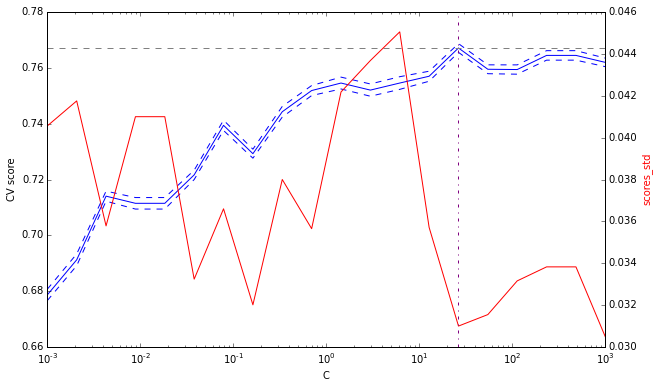

In [206]:
plot_1D_search(clf_logit, 'C', Cs, grid_search_logit.best_params_['C'], log=True)

### Model Assessment

In [207]:
# Presenting prediction performance on test data using the fitted model
present_test_result(best_models['logistic regression'], X_test_aug)

Accuracy: 0.787878787879

             precision    recall  f1-score   support

          0       0.79      0.80      0.80        51
          1       0.79      0.77      0.78        48

avg / total       0.79      0.79      0.79        99


Confusion Matrix:

    0   1
0  41  10
1  11  37


ROC Curve for Logistic Regression
ROC_AUC: 0.810049019608


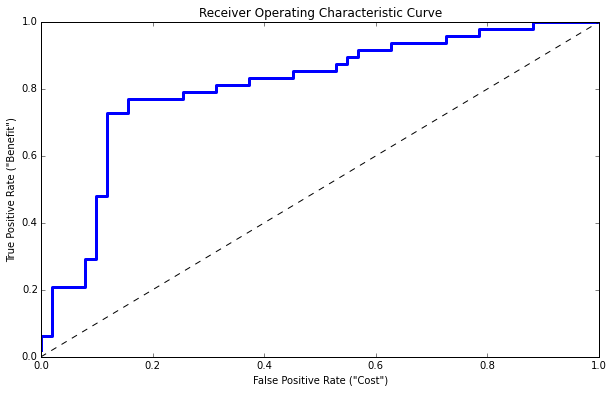

In [208]:
# Plotting the ROC Curve
print "ROC Curve for Logistic Regression"
plot_roc(best_models['logistic regression'], X_test_aug)

## Classification Tree

### Model Estimation using Cross-validated Grid-search

In [209]:
# Classification tree with min_samples_split to be tuned
print '_'*20 + ' Classification Tree ' + '_'*20 + '\n' 
clf_dt = DecisionTreeClassifier(random_state=99)
min_splits = range(1,301)
grid_search_dt = GridSearchCV(clf_dt, {'min_samples_split': min_splits}, cv=5, verbose=3)

# Fitting
start = time()
grid_search_dt.fit(X_train_aug, y_train)
end = time()

____________________ Classification Tree ____________________

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.787500 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.800000 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.696203 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.820513 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.679487 -   0.0s
[CV] min_samples_split=2 .............................................
[CV] .................... min_samples_split=2, score=0.787500 -   0.0s
[CV] min_samples_spli

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    0.1s



[CV] min_samples_split=5 .............................................
[CV] .................... min_samples_split=5, score=0.782051 -   0.0s
[CV] min_samples_split=5 .............................................
[CV] .................... min_samples_split=5, score=0.705128 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.800000 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.800000 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.683544 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.782051 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.705128 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:    1.2s



[CV] min_samples_split=56 ............................................
[CV] ................... min_samples_split=56, score=0.730769 -   0.0s
[CV] min_samples_split=57 ............................................
[CV] ................... min_samples_split=57, score=0.762500 -   0.0s
[CV] min_samples_split=57 ............................................
[CV] ................... min_samples_split=57, score=0.737500 -   0.0s
[CV] min_samples_split=57 ............................................
[CV] ................... min_samples_split=57, score=0.746835 -   0.0s
[CV] min_samples_split=57 ............................................
[CV] ................... min_samples_split=57, score=0.756410 -   0.0s
[CV] min_samples_split=57 ............................................
[CV] ................... min_samples_split=57, score=0.730769 -   0.0s
[CV] min_samples_split=58 ............................................
[CV] ................... min_samples_split=58, score=0.762500 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    2.8s



[CV] min_samples_split=157 ...........................................
[CV] .................. min_samples_split=157, score=0.692308 -   0.0s
[CV] min_samples_split=158 ...........................................
[CV] .................. min_samples_split=158, score=0.725000 -   0.0s
[CV] min_samples_split=158 ...........................................
[CV] .................. min_samples_split=158, score=0.712500 -   0.0s
[CV] min_samples_split=158 ...........................................
[CV] .................. min_samples_split=158, score=0.759494 -   0.0s
[CV] min_samples_split=158 ...........................................
[CV] .................. min_samples_split=158, score=0.653846 -   0.0s
[CV] min_samples_split=158 ...........................................
[CV] .................. min_samples_split=158, score=0.692308 -   0.0s
[CV] min_samples_split=159 ...........................................
[CV] .................. min_samples_split=159, score=0.725000 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    4.6s finished



[CV] min_samples_split=298 ...........................................
[CV] .................. min_samples_split=298, score=0.756410 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.737500 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.662500 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.696203 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.679487 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.756410 -   0.0s
[CV] min_samples_split=300 ...........................................
[CV] .................. min_samples_split=300, score=0.737500 -   0.0s
[CV] 

In [210]:
# Report Estimation Result
print("Classification Tree Estimation using GridSearchCV took %.2f seconds"
      "\nBest Parameter settings:" % ((end - start)))
print '_'*25 + '\n'
report(grid_search_dt.grid_scores_)

best_models['classification tree'] = grid_search_dt.best_estimator_

Classification Tree Estimation using GridSearchCV took 4.63 seconds
Best Parameter settings:
_________________________

Model with rank: 1
Mean validation score: 0.780 (std: 0.052)
Parameters: {'min_samples_split': 27}

Model with rank: 2
Mean validation score: 0.780 (std: 0.052)
Parameters: {'min_samples_split': 28}

Model with rank: 3
Mean validation score: 0.775 (std: 0.055)
Parameters: {'min_samples_split': 26}



### Visualizing the Parameter Search

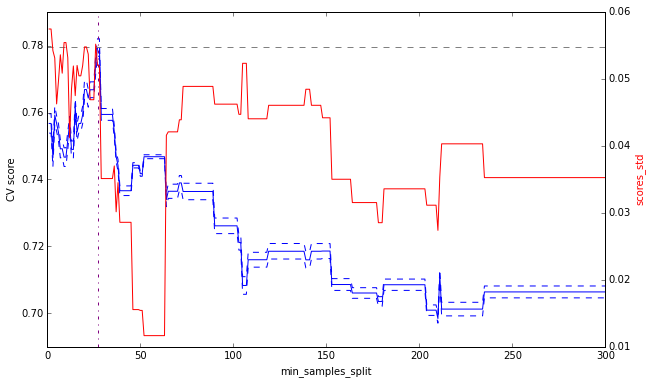

In [211]:
plot_1D_search(clf_dt, 'min_samples_split',
               min_splits, grid_search_dt.best_params_['min_samples_split'], log=False)

### Visualizing the Fitted Classification Tree

In [212]:
# Helper Function for Drawing the Tree
def visualize_tree(tree, feature_names, out_filename):
    """
    Create tree png using graphviz
    Credit: cstrelioff@GitHub

    """
    out_dot = out_filename + ".dot"
    out_png = out_filename + ".png"
    with open(out_dot, 'w') as f:
        export_graphviz(tree, out_file=f, feature_names=feature_names)

    command = ["dot", "-Tpng", out_dot, "-o", out_png]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to produce visualization")

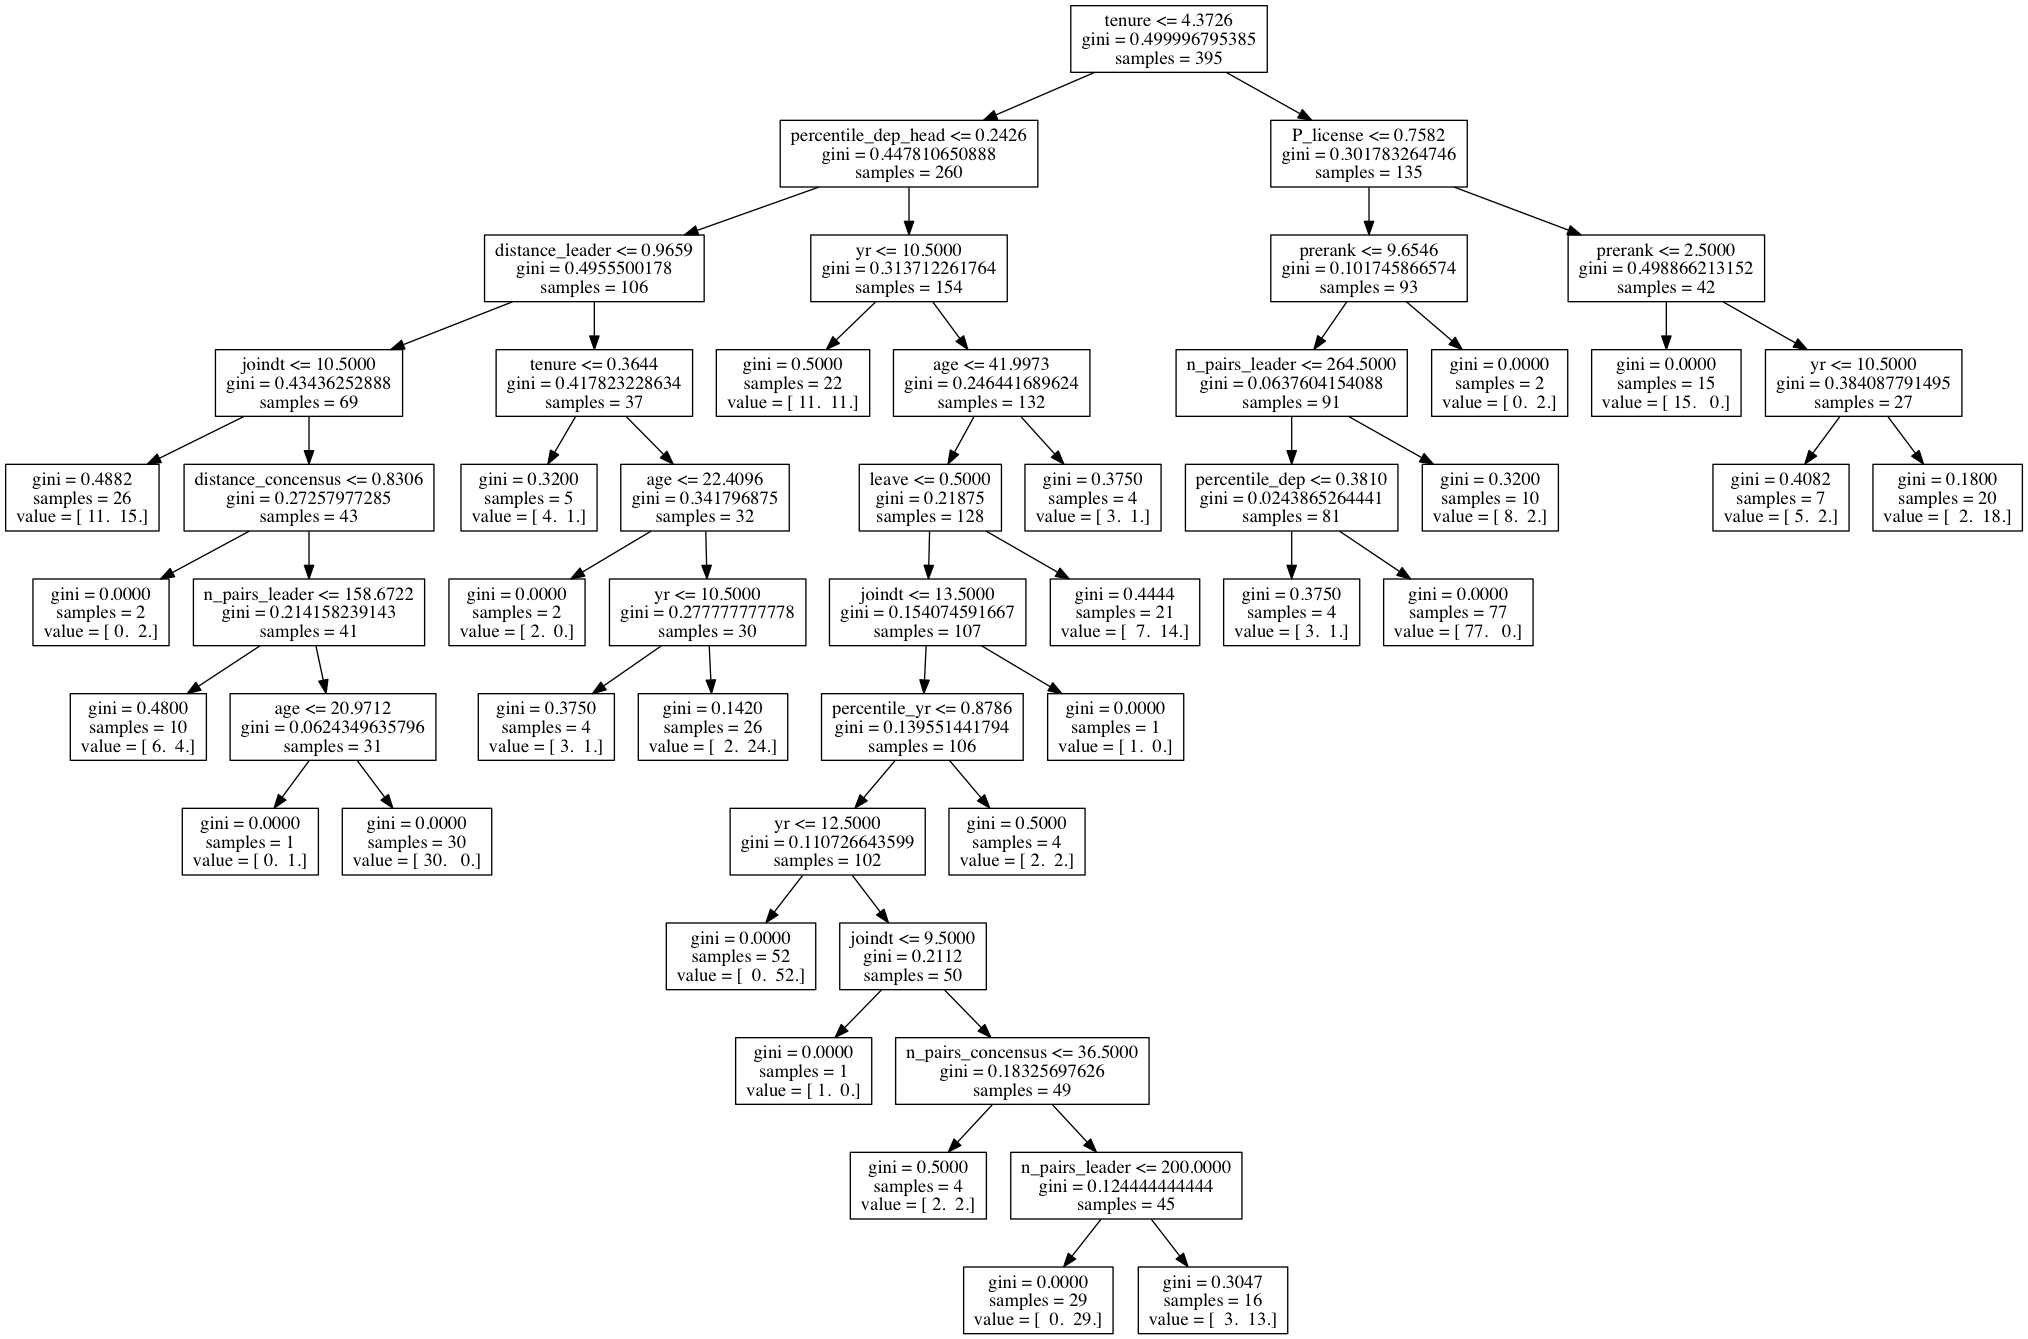

In [213]:
visualize_tree(best_models['classification tree'], list(X_train_aug.columns.values), 'clf_dt')
Image(filename='clf_dt.png') 

### Performance Without the Features Extracted from 360-degree Appraisal

In [214]:
# Classification tree with min_samples_split to be tuned
print '_'*20 + ' Classification Tree without Additional Features' + '_'*20 + '\n' 
clf_dt_W = DecisionTreeClassifier(random_state=99)
grid_search_dt_W = GridSearchCV(clf_dt_W, {'min_samples_split': min_splits}, cv=5, verbose=3)

# Fitting
start = time()
grid_search_dt_W.fit(X_train, y_train)
end = time()

____________________ Classification Tree without Additional Features____________________

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.800000 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.825000 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.683544 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.833333 -   0.0s
[CV] min_samples_split=1 .............................................
[CV] .................... min_samples_split=1, score=0.756410 -   0.0s
[CV] min_samples_split=2 .............................................
[CV] .................... min_samples_split=2, score=0.800000 -  

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  32 jobs       | elapsed:    0.1s



[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.812500 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.812500 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.658228 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.833333 -   0.0s
[CV] min_samples_split=6 .............................................
[CV] .................... min_samples_split=6, score=0.743590 -   0.0s
[CV] min_samples_split=7 .............................................
[CV] .................... min_samples_split=7, score=0.800000 -   0.0s
[CV] min_samples_split=7 .............................................
[CV] .................... min_samples_split=7, score=0.812500 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 128 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 288 jobs       | elapsed:    1.1s



[CV] min_samples_split=58 ............................................
[CV] ................... min_samples_split=58, score=0.737500 -   0.0s
[CV] min_samples_split=58 ............................................
[CV] ................... min_samples_split=58, score=0.746835 -   0.0s
[CV] min_samples_split=58 ............................................
[CV] ................... min_samples_split=58, score=0.756410 -   0.0s
[CV] min_samples_split=58 ............................................
[CV] ................... min_samples_split=58, score=0.666667 -   0.0s
[CV] min_samples_split=59 ............................................
[CV] ................... min_samples_split=59, score=0.762500 -   0.0s
[CV] min_samples_split=59 ............................................
[CV] ................... min_samples_split=59, score=0.737500 -   0.0s
[CV] min_samples_split=59 ............................................
[CV] ................... min_samples_split=59, score=0.746835 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 512 jobs       | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    2.7s



[CV] min_samples_split=159 ...........................................
[CV] .................. min_samples_split=159, score=0.759494 -   0.0s
[CV] min_samples_split=159 ...........................................
[CV] .................. min_samples_split=159, score=0.653846 -   0.0s
[CV] min_samples_split=159 ...........................................
[CV] .................. min_samples_split=159, score=0.692308 -   0.0s
[CV] min_samples_split=160 ...........................................
[CV] .................. min_samples_split=160, score=0.725000 -   0.0s
[CV] min_samples_split=160 ...........................................
[CV] .................. min_samples_split=160, score=0.712500 -   0.0s
[CV] min_samples_split=160 ...........................................
[CV] .................. min_samples_split=160, score=0.759494 -   0.0s
[CV] min_samples_split=160 ...........................................
[CV] .................. min_samples_split=160, score=0.653846 -   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done 1152 jobs       | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:    4.4s finished



[CV] .................. min_samples_split=298, score=0.737500 -   0.0s
[CV] min_samples_split=298 ...........................................
[CV] .................. min_samples_split=298, score=0.662500 -   0.0s
[CV] min_samples_split=298 ...........................................
[CV] .................. min_samples_split=298, score=0.696203 -   0.0s
[CV] min_samples_split=298 ...........................................
[CV] .................. min_samples_split=298, score=0.679487 -   0.0s
[CV] min_samples_split=298 ...........................................
[CV] .................. min_samples_split=298, score=0.756410 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.737500 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] .................. min_samples_split=299, score=0.662500 -   0.0s
[CV] min_samples_split=299 ...........................................
[CV] 

In [215]:
# Report Estimation Result
print("Classification Tree (without addditional features) Estimation using GridSearchCV took %.2f seconds"
      "\nBest Parameter settings:" % ((end - start)))
print '_'*25 + '\n'
report(grid_search_dt_W.grid_scores_)

best_models['classification tree (W)'] = grid_search_dt_W.best_estimator_

Classification Tree (without addditional features) Estimation using GridSearchCV took 4.44 seconds
Best Parameter settings:
_________________________

Model with rank: 1
Mean validation score: 0.787 (std: 0.064)
Parameters: {'min_samples_split': 21}

Model with rank: 2
Mean validation score: 0.785 (std: 0.063)
Parameters: {'min_samples_split': 22}

Model with rank: 3
Mean validation score: 0.785 (std: 0.056)
Parameters: {'min_samples_split': 23}



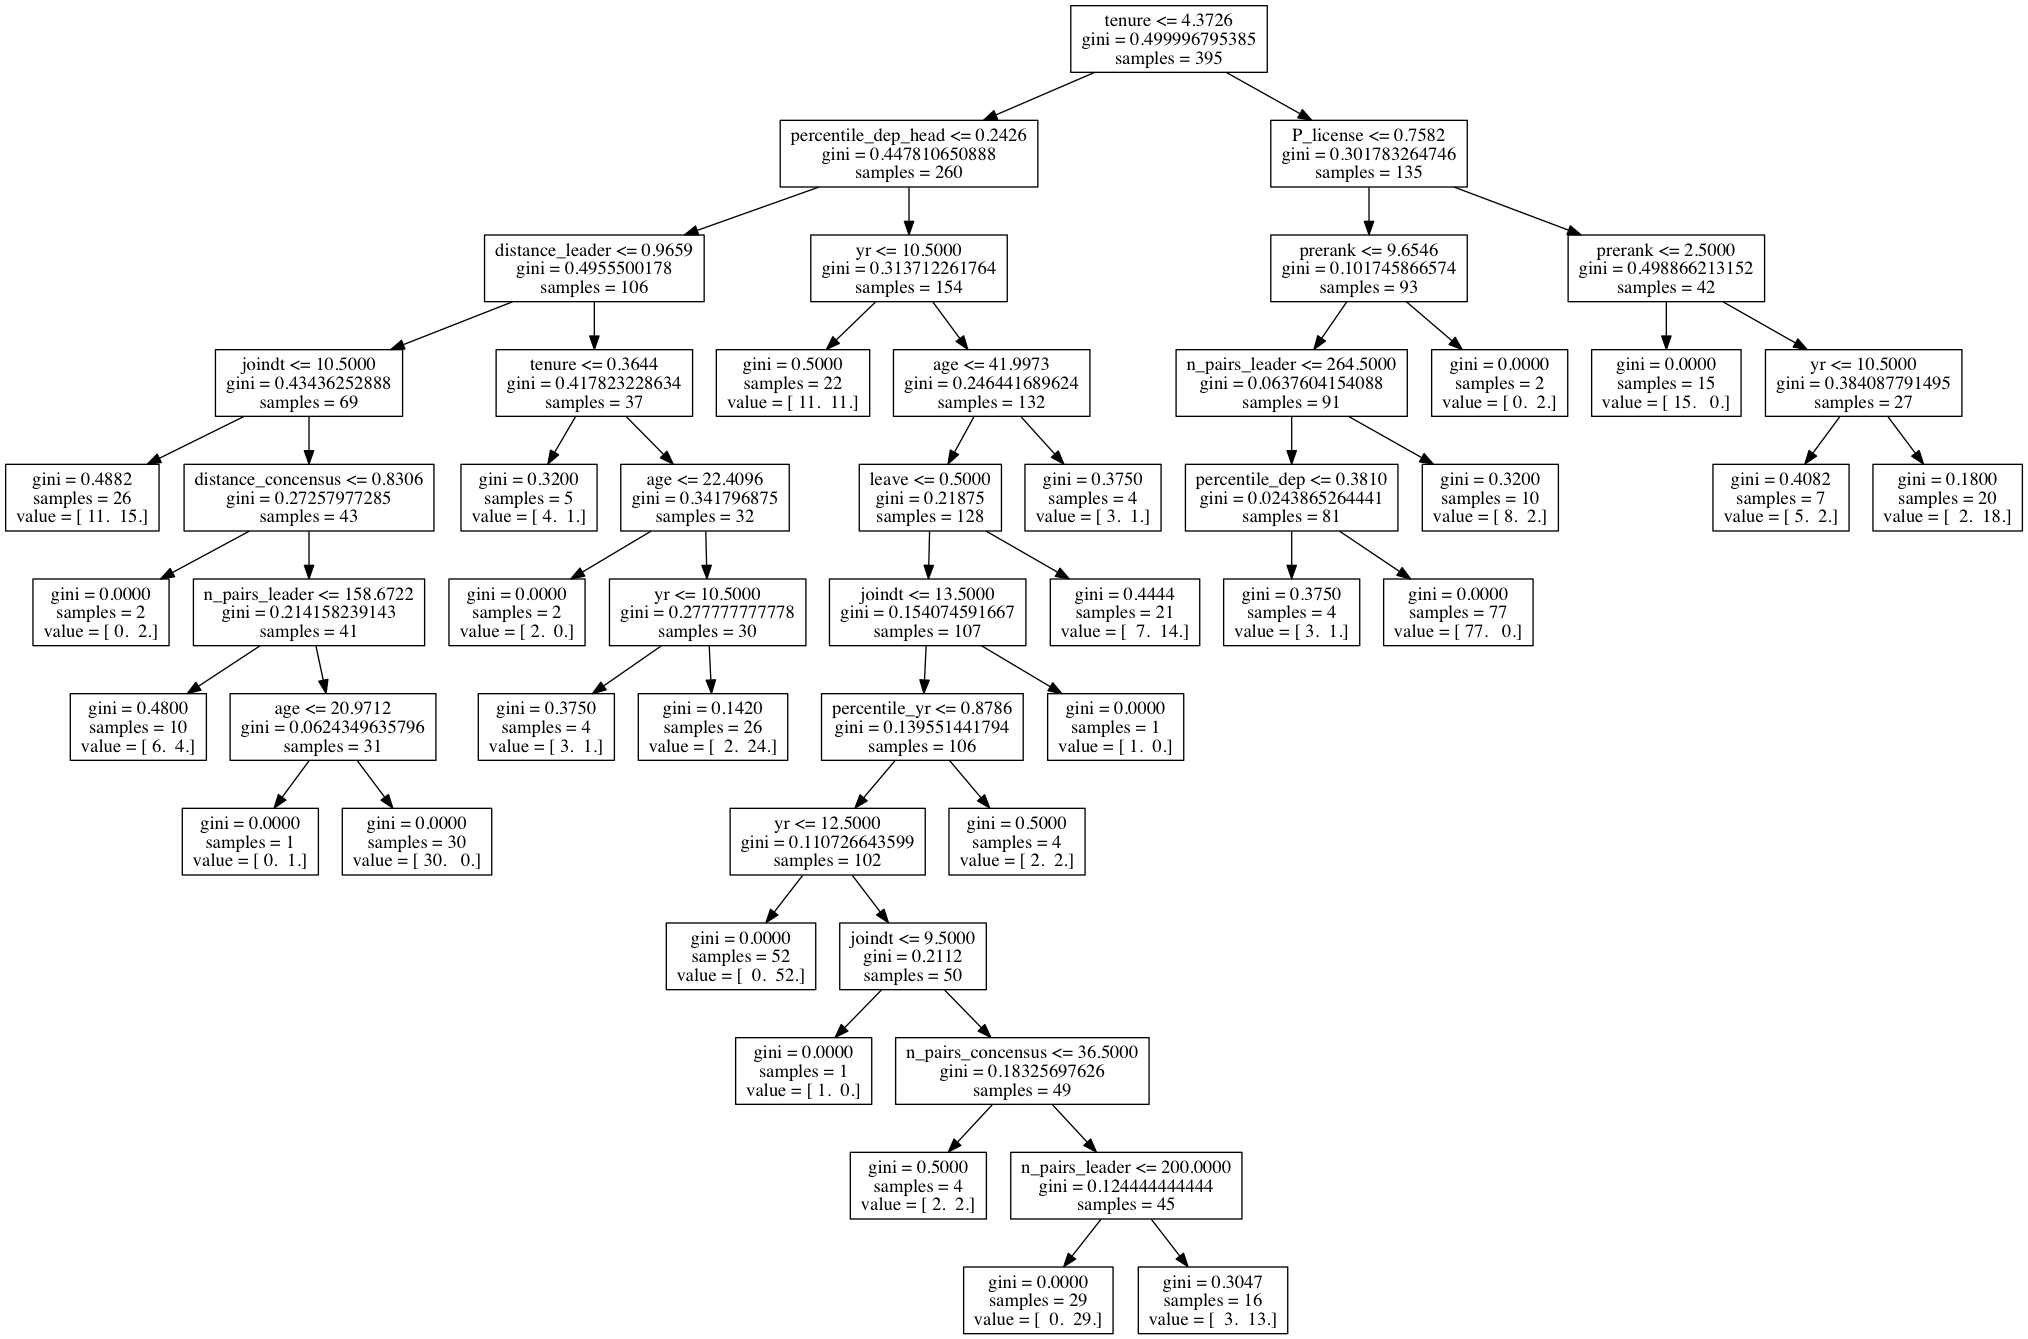

In [216]:
# Visualizing the Tree (Without Additional Features)
visualize_tree(best_models['classification tree'], list(X_train_aug.columns.values), 'clf_dt_W')
Image(filename='clf_dt_W.png') 

### Comparison: With and Without Additional Features

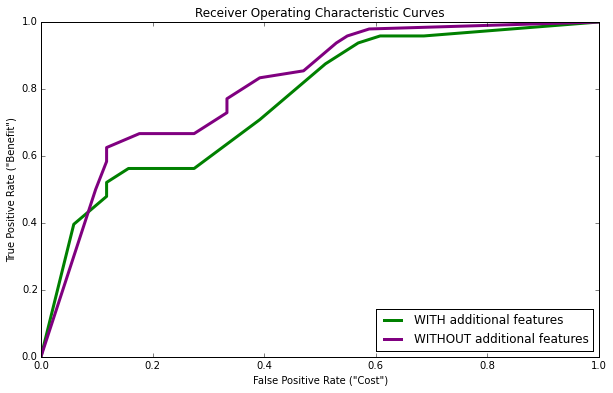

In [240]:
plot_two_rocs(best_models['classification tree'], X_test_aug, 'green', 'WITH additional features',
             best_models['classification tree (W)'], X_test, 'purple', 'WITHOUT additional features')


In [225]:
print "Metrics for Classification Tree\n"
present_test_result(best_models['classification tree'], X_test_aug)

print  "\n" + "-"*50 

print "Metrics for Classification Tree (Without Additional Features)\n"
present_test_result(best_models['classification tree (W)'], X_test)

Metrics for Classification Tree

Accuracy: 0.656565656566

             precision    recall  f1-score   support

          0       0.69      0.61      0.65        51
          1       0.63      0.71      0.67        48

avg / total       0.66      0.66      0.66        99


Confusion Matrix:

    0   1
0  31  20
1  14  34

--------------------------------------------------
Metrics for Classification Tree (Without Additional Features)

Accuracy: 0.69696969697

             precision    recall  f1-score   support

          0       0.72      0.67      0.69        51
          1       0.67      0.73      0.70        48

avg / total       0.70      0.70      0.70        99


Confusion Matrix:

    0   1
0  34  17
1  13  35


## Random Forest 

In [ ]:
parameter_grid = {
    'max_features': range(3,20),
    'max_depth': range(1,10),
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators = 500, random_state = 99), parameter_grid,
                            cv=5, verbose=3)


In [ ]:
grid_search.fit(X_train_aug, y_train)

In [ ]:
sorted(grid_search.grid_scores_, key=lambda x: x.mean_validation_score)
print grid_search.best_score_
print grid_search.best_params_

In [ ]:
print '_'*20 + ' Random Forest Classifier ' + '_'*20 + '\n'      
# INIT RANDOM FOREST CLASSIFER
clf_rf = RandomForestClassifier(random_state=99)

# PARAMETER DISTRIBUTION FOR RANDOM FOREST CLASSIFIER
param_dist_rf = {"max_depth": st.randint(2,12),
                 "n_estimators": st.randint(50,1000),
                 "max_features": st.randint(1,30),
                 "bootstrap": [True, False],
                 "criterion": ["gini", "entropy"]}

# RUN PARAMETER ESTIMATION
n_iter_search = 50
random_search_rf = RandomizedSearchCV(clf_rf, param_distributions=param_dist_rf,
                                      n_iter=n_iter_search, scoring = 'roc_auc')
# FIT
start = time()
random_search_rf.fit(X_train_aug, y_train)

print("Random Forest Classifier Estimation using RandomizedSearchCV took %.2f seconds for %d candidates models"
      "\nBest Parameter settings:" % ((time() - start), n_iter_search))
print '_'*25 + '\n'
report(random_search_rf.grid_scores_)

#best_models['random_forest'] = random_search_rf.best_estimator_

In [ ]:
y_rf1 = random_search_rf.best_estimator_.predict(X_test_aug)

In [ ]:

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=500, random_state=99)

forest.fit(X_train_aug, y_train)

features = list(X_train_aug.columns.values)
importances = forest.feature_importances_

feature_imp = pd.DataFrame({'importance':importances, 'feature':features})
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
feature_imp['std'] = std
feature_imp_sorted = feature_imp.sort(['importance'], ascending = False)
print "Top 10 Most Important Features:"
feature_imp_sorted.head(10)

In [ ]:
# Plot the feature importances from random forest
plt.figure(figsize = (8,12))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), feature_imp_sorted['importance'].values,
       color="r", xerr=feature_imp_sorted['std'].values, align="center")
plt.yticks(range(X.shape[1]), feature_imp_sorted['feature'].values)
plt.ylim([-1, X.shape[1]])
plt.ylim(plt.ylim()[::-1]) #inverse the ylim so that features start with the highest importance
plt.xlim([0, feature_imp_sorted['importance'].max(0) + 1.2*feature_imp_sorted['std'].max(0)])
plt.show()